In [2]:
from importlib import reload
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import os
import random
from tqdm import tqdm
import copy

In [3]:
import time

In [4]:
import gng

In [5]:
import data_utils
reload(data_utils)

data_ranges = [
    [ [-14.0, -2.0], [6.0, 16.0] ],
    [ [2.0, 15.0],   [-8.0, 6.0] ],
    [ [-12.0, -4.0], [-14.0, -6.0] ]
]
data, labels = data_utils.generate_data(data_ranges, length=100)

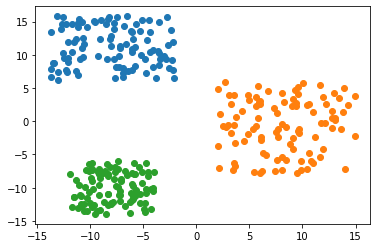

In [6]:
data_sep, uniq_labels = data_utils.split_data(data, labels)
data_utils.plt_graph_sep_data(data_sep)

In [13]:
reload(gng)
gng_model = gng.GNG()
neurons, error = gng_model.train(data,
                epochs=1000, 
                learning_b=.5, 
                learning_n=.01, 
                age_max=4, 
                gamma=5,
                error_alpha=.1,
                error_d=.98)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:11<00:00,  5.23it/s]


# Paint data

In [7]:
from PIL import Image

In [8]:
paint_class_1 = Image.open('data/paint_dataset_class1.png')
paint_class_1 = np.array(paint_class_1)
paint_class_2 = Image.open('data/paint_dataset_class2.png')
paint_class_2 = np.array(paint_class_2)

In [9]:
class_1 = []
for j,row in enumerate(paint_class_1):
    for i,col in enumerate(row):
        if(not np.array_equal(col, [255, 255, 255, 255])):
            class_1.append(np.array([i,-j]))
class_1 = np.array(class_1)

In [10]:
class_2 = []
for j,row in enumerate(paint_class_2):
    for i,col in enumerate(row):
        if(not np.array_equal(col, [255, 255, 255, 255])):
            class_2.append(np.array([i,-j]))
class_2 = np.array(class_2)

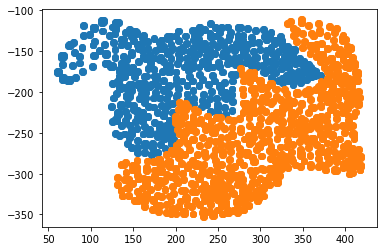

In [11]:
data_utils.plt_graph_sep_data([class_1, class_2])

In [88]:
reload(gng)
gng_model = gng.GNG()
neurons, error = gng_model.train(class_1,
                epochs=1500, 
                learning_b=.5, 
                learning_n=.01, 
                age_max=4, 
                gamma=5,
                error_alpha=.1,
                error_d=.98,
                error_target=100)

 26%|████████████████████████████▍                                                                                  | 385/1500 [00:55<02:39,  6.97it/s]

Error target met!


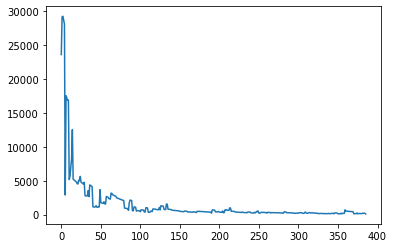

In [89]:
fig, ax = plt.subplots()
ax.plot(error)
plt.show()

# Data utils

In [27]:
def split_data(data, labels):
    data_sep = []
    uniq_labels = list(set(sorted(labels)))
    for cl in uniq_labels:
        data_class = np.zeros((1,2))
        for i,lab in enumerate(labels):
            if(cl == lab):
                data_class = np.append(data_class, [data[i]], axis=0)
        data_class = data_class[1:]
        data_sep.append(data_class)
    return data_sep, uniq_labels

# graph separated data w/ plt
def plt_graph_sep_data(data):
    fig, ax = plt.subplots()
    for cl in data:
        ax.scatter(cl[:,0], cl[:,1])
    plt.show()

def classify(pred, labels):
    if(type(pred) == np.ndarray):
        typ = -np.inf
        cls = 0
        for i,p in enumerate(pred):
            if(p > typ):
                typ = p
                cls = i
        return cls
        
    else:
        uniqs = list(set(sorted(labels)))
        min_d = np.inf
        min_i = 0
        for i,l in enumerate(uniqs):
            dis = abs(pred - l)
            if(dis < min_d):
                min_d = dis
                min_i = i
        return uniqs[min_i]
    
def test_model(model, data, labels, centers):
    # new_data = np.array([*data[0:2], *data[100:102], *data[200:202]])
    # print(new_data.shape)
    truepos = 0
    preds = []
    for d, l in zip(data, labels):
        pred = model.forward(d)
#         print(pred)
        pred = classify(pred,labels)
        preds.append(pred)
        if(pred == l):
            truepos += 1

    accuracy = truepos / len(data)
    print('Accuracy:', round(accuracy,2))
    
    data_sep, uniq_labels = split_data(data, preds)
    data_sep.append(centers)
    plt_graph_sep_data(data_sep)
    
    return preds

In [29]:
def grid_search(data, model, step=(.5,.5)):
    # generate data
    x = np.arange(min(data[:,0]), max(data[:,0]), step[0])
    y = np.arange(min(data[:,1]), max(data[:,1]), step[1])

    # grid_xy = np.zeros((len(x), len(x)))
    xy_data  = []
    xy_preds = []
    z_preds  = np.zeros((len(x), len(y)))
    z_data   = np.zeros((len(x), len(y)))
    for i in tqdm(range(len(x))):
        for j in range(len(y)):
            pred = model.forward([x[i], y[j]])
            z    = copy.deepcopy(pred)
            pred = classify(pred,labels)
            xy_data.append([x[i], y[j]])
            xy_preds.append(pred)
            z_preds[i,j] = pred
            z_data[i,j]  = z
    
    # predict on grid
    xy_sep, xy_uniq_labels = split_data(xy_data, xy_preds)
    plt_graph_sep_data(xy_sep)
    
    # Plot surface - raw predictions
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xy_data, xy_preds, z_data = np.array(xy_data), np.array(xy_preds), np.array(z_data)
    Y, X = np.meshgrid(y, x)
    ax.plot_surface(X, Y, z_data, cmap=cm.coolwarm)
    plt.show()

# Raw RBN

In [16]:
combined_x = []
combined_y = []
for i, cls in enumerate([class_1, class_2]):
    for d in cls:
        combined_x.append(d)
        combined_y.append(i)
combined_x = np.array(combined_x)
combined_y = np.array(combined_y)

In [ ]:
import gen_rbn_gd
reload(gen_rbn_gd)

t0 = time.time()


rbnetwork = gen_rbn_gd.RBN(k=500, outputs=1)
error, centers = rbnetwork.train(
    combined_x, 
    combined_y, 
    alpha=1e-4, 
    epochs=200, 
    batch_size=500, 
    dw_target=.001,
    save_config=True
)


t1 = time.time()
print('Time to complete:', t1-t0)

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 181/200 [06:57<00:43,  2.31s/it]

Accuracy: 0.88


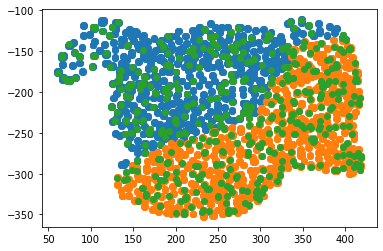

In [36]:
preds = test_model(rbnetwork, combined_x, combined_y, centers)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:19<00:00,  3.75it/s]


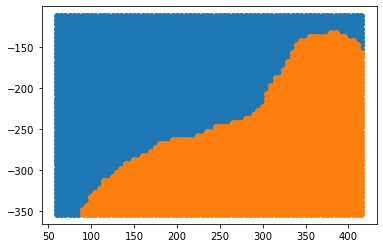

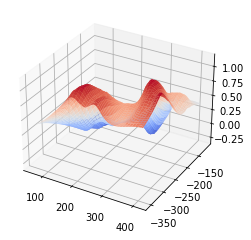

In [37]:
grid_search(combined_x, rbnetwork, step=(5, 5))

# GNG to SVM

In [ ]:
import gen_rbn_gd
reload(gen_rbn_gd)
reload(gng)

t0 = time.time()


gng_model_1 = gng.GNG()
neurons_1, error_1 = gng_model_1.train(class_1,
                epochs=1500, 
                learning_b=.5, 
                learning_n=.01, 
                age_max=4, 
                gamma=5,
                error_alpha=.1,
                error_d=.98,
                error_target=35)

gng_model_2 = gng.GNG()
neurons_2, error_2 = gng_model_2.train(class_2,
                epochs=1500, 
                learning_b=.5, 
                learning_n=.01, 
                age_max=4, 
                gamma=5,
                error_alpha=.1,
                error_d=.98,
                error_target=35)


gng_combined_x = []
gng_combined_y = []
for i, cls in enumerate([neurons_1, neurons_2]):
    for d in cls:
        gng_combined_x.append(d)
        gng_combined_y.append(i)
gng_combined_x = np.array(gng_combined_x)
gng_combined_y = np.array(gng_combined_y)


rbnetwork = gen_rbn_gd.RBN(k=500, outputs=1)
error, centers = rbnetwork.train(
    gng_combined_x, 
    gng_combined_y, 
    alpha=1e-3, 
    epochs=200, 
    batch_size=500, 
    dw_target=.001,
    save_config=True
)



t1 = time.time()
print('Time to complete:', t1-t0)